# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops
print(tf.__version__)
if tf.__version__ < '1.14.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')


/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

1.12.0


ImportError: Please upgrade your tensorflow installation to v1.4.* or later!

## Env setup

In [ ]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [2]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [3]:
# # What model to download.
# MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
# MODEL_FILE = MODEL_NAME + '.tar.gz'
# DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# # Path to frozen detection graph. This is the actual model that is used for the object detection.
# PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# # List of the strings that is used to add correct label for each box.
# PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

# NUM_CLASSES = 90

In [4]:
# What model to download.
MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'oid_v4_label_map.pbtxt')

NUM_CLASSES = 601


In [5]:
# # facessd_mobilenet_v2_quantized_320x320_open_image_v4.tar.gz
# # What model to download.
# MODEL_NAME = 'facessd_mobilenet_v2_quantized_320x320_open_image_v4'
# MODEL_FILE = MODEL_NAME + '.tar.gz'
# DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# # Path to frozen detection graph. This is the actual model that is used for the object detection.
# PATH_TO_CKPT = MODEL_NAME + '/tflite_graph.pb'

# # List of the strings that is used to add correct label for each box.
# PATH_TO_LABELS = os.path.join(MODEL_NAME, 'face_label_map.pbtxt')

# NUM_CLASSES = 600  

In [6]:
# # oid_bbox_trainable_label_map is wrong /faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12.tar.gz    
#     # What model to download.
# MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12'
# MODEL_FILE = MODEL_NAME + '.tar.gz'
# DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# # Path to frozen detection graph. This is the actual model that is used for the object detection.
# PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# # List of the strings that is used to add correct label for each box.
# PATH_TO_LABELS = os.path.join('data', 'oid_bbox_trainable_label_map.pbtxt')

# NUM_CLASSES = 545

In [7]:
# #ok:correct!oid_v4_label_map /ssd_resnet101_v1_fpn_shared_box_predictor_oid_512x512_sync_2019_01_20.tar.gz
    
#     # What model to download.
# MODEL_NAME = 'ssd_resnet101_v1_fpn_shared_box_predictor_oid_512x512_sync_2019_01_20'
# MODEL_FILE = MODEL_NAME + '.tar.gz'
# DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# # Path to frozen detection graph. This is the actual model that is used for the object detection.
# PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# # List of the strings that is used to add correct label for each box.
# PATH_TO_LABELS = os.path.join('data', 'oid_v4_label_map.pbtxt')

# NUM_CLASSES = 601

In [8]:
print(MODEL_NAME)
print(PATH_TO_LABELS)

faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12
data/oid_v4_label_map.pbtxt


## Download Model

In [46]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [9]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [10]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [11]:
print((label_map))


item {
  name: "/m/011k07"
  id: 1
  display_name: "Tortoise"
}
item {
  name: "/m/011q46kg"
  id: 2
  display_name: "Container"
}
item {
  name: "/m/012074"
  id: 3
  display_name: "Magpie"
}
item {
  name: "/m/0120dh"
  id: 4
  display_name: "Sea turtle"
}
item {
  name: "/m/01226z"
  id: 5
  display_name: "Football"
}
item {
  name: "/m/012n7d"
  id: 6
  display_name: "Ambulance"
}
item {
  name: "/m/012w5l"
  id: 7
  display_name: "Ladder"
}
item {
  name: "/m/012xff"
  id: 8
  display_name: "Toothbrush"
}
item {
  name: "/m/012ysf"
  id: 9
  display_name: "Syringe"
}
item {
  name: "/m/0130jx"
  id: 10
  display_name: "Sink"
}
item {
  name: "/m/0138tl"
  id: 11
  display_name: "Toy"
}
item {
  name: "/m/013y1f"
  id: 12
  display_name: "Organ"
}
item {
  name: "/m/01432t"
  id: 13
  display_name: "Cassette deck"
}
item {
  name: "/m/014j1m"
  id: 14
  display_name: "Apple"
}
item {
  name: "/m/014sv8"
  id: 15
  display_name: "Human eye"
}
item {
  name: "/m/014trl"
  id: 16
  di

## Helper code

In [12]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [13]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [14]:
# def run_inference_for_single_image(image, graph):
#   with graph.as_default():
#     with tf.Session() as sess:
#       # Get handles to input and output tensors
#       ops = tf.get_default_graph().get_operations()
#       all_tensor_names = {output.name for op in ops for output in op.outputs}
#       tensor_dict = {}
#       for key in [
#           'num_detections', 'detection_boxes', 'detection_scores',
#           'detection_classes', 'detection_masks'
#       ]:
#         tensor_name = key + ':0'
#         if tensor_name in all_tensor_names:
#           tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
#               tensor_name)
#       if 'detection_masks' in tensor_dict:
#         # The following processing is only for single image
#         detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
#         detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
#         # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
#         real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
#         detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
#         detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
#         detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
#             detection_masks, detection_boxes, image.shape[0], image.shape[1])
#         detection_masks_reframed = tf.cast(
#             tf.greater(detection_masks_reframed, 0.5), tf.uint8)
#         # Follow the convention by adding back the batch dimension
#         tensor_dict['detection_masks'] = tf.expand_dims(
#             detection_masks_reframed, 0)
#       image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

#       # Run inference
#       output_dict = sess.run(tensor_dict,
#                              feed_dict={image_tensor: np.expand_dims(image, 0)})

#       # all outputs are float32 numpy arrays, so convert types as appropriate
#       output_dict['num_detections'] = int(output_dict['num_detections'][0])
#       output_dict['detection_classes'] = output_dict[
#           'detection_classes'][0].astype(np.uint8)
#       output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
#       output_dict['detection_scores'] = output_dict['detection_scores'][0]
#       if 'detection_masks' in output_dict:
#         output_dict['detection_masks'] = output_dict['detection_masks'][0]
#   return output_dict

In [15]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

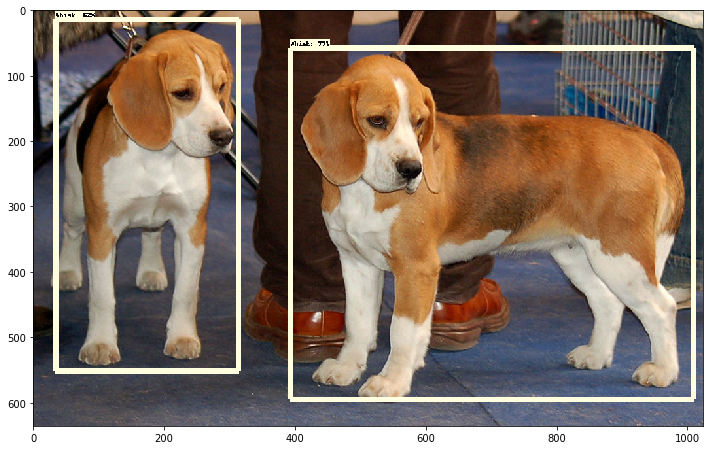

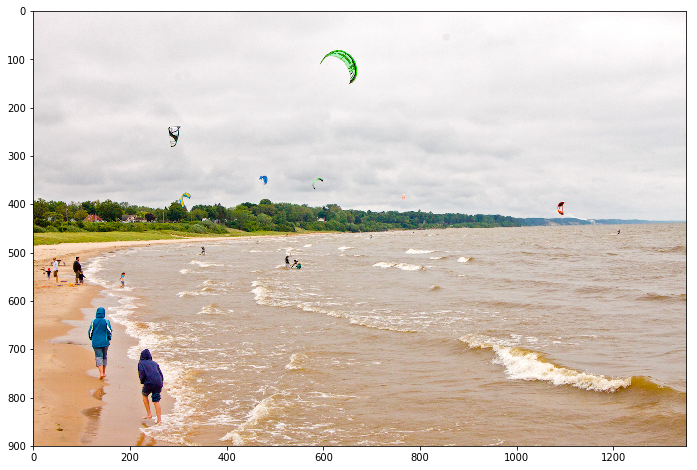

In [23]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

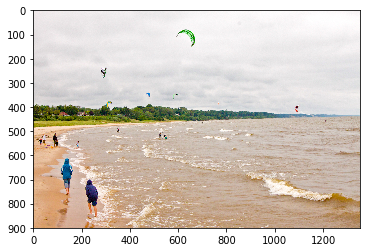

In [22]:
plt.imshow(image)

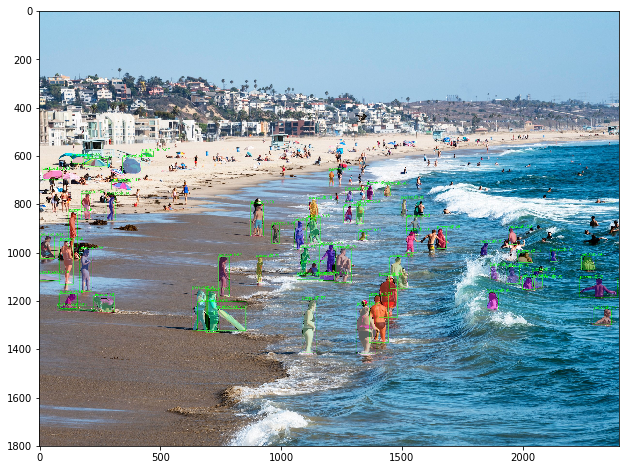

In [36]:
image_path='/root/Mask_RCNN/images/sea_people.jpg'
image = Image.open(image_path)
# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it.
image_np = load_image_into_numpy_array(image)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image_np, axis=0)
# Actual detection.
output_dict = run_inference_for_single_image(image_np, detection_graph)
# Visualization of the results of a detection.
vis_util.visualize_boxes_and_labels_on_image_array(
  image_np,
  output_dict['detection_boxes'],
  output_dict['detection_classes'],
  output_dict['detection_scores'],
  category_index,
  instance_masks=output_dict.get('detection_masks'),
  use_normalized_coordinates=True,
  line_thickness=8)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)

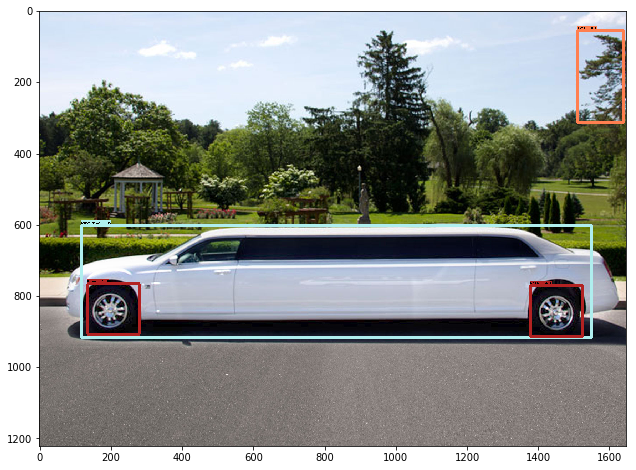

In [73]:
#Limousine.jpg
image_path='/root/Mask_RCNN/images/Limousine.jpg'
image = Image.open(image_path)
# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it.
image_np = load_image_into_numpy_array(image)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image_np, axis=0)
# Actual detection.
output_dict = run_inference_for_single_image(image_np, detection_graph)
# Visualization of the results of a detection.
vis_util.visualize_boxes_and_labels_on_image_array(
  image_np,
  output_dict['detection_boxes'],
  output_dict['detection_classes'],
  output_dict['detection_scores'],
  category_index,
  instance_masks=output_dict.get('detection_masks'),
  use_normalized_coordinates=True,
  line_thickness=8,
    min_score_thresh=.2)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)


In [74]:
output_dict['detection_classes']

array([ 89, 409, 409, 391,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1])

In [ ]:
output_dict

In [16]:


#Limousine.jpg
image_path='/root/Mask_RCNN/images/seahorse.jpg'
image = Image.open(image_path)
# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it.
image_np = load_image_into_numpy_array(image)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image_np, axis=0)
# Actual detection.
output_dict = run_inference_for_single_image(image_np, detection_graph)
# Visualization of the results of a detection.
vis_util.visualize_boxes_and_labels_on_image_array(
  image_np,
  output_dict['detection_boxes'],
  output_dict['detection_classes'],
  output_dict['detection_scores'],
  category_index,
  instance_masks=output_dict.get('detection_masks'),
  use_normalized_coordinates=True,
  line_thickness=8,
    min_score_thresh=.5)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)



In [17]:
vis_util.visualize_boxes_and_labels_on_image_array(
  image_np,
  output_dict['detection_boxes'],
  output_dict['detection_classes'],
  output_dict['detection_scores'],
  category_index,
  instance_masks=output_dict.get('detection_masks'),
  use_normalized_coordinates=True,
  line_thickness=8,
    min_score_thresh=.5)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)

In [18]:
output_dict

{'detection_boxes': array([[0.02738034, 0.37157205, 0.9216316 , 0.93397355],
        [0.19072047, 0.15375204, 0.9634084 , 0.5078366 ],
        [0.05039552, 0.3023163 , 0.8926607 , 0.7510283 ],
        [0.18198164, 0.16367342, 1.        , 0.4815098 ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.      

In [ ]:
fig.savefig('temp.png', dpi=fig.dpi)


In [25]:
import time
start_time = time.time()
numofImages = 10
for ii in range(numofImages):
    # Run detection
    run_inference_for_single_image(image_np, detection_graph)

lfw_time = time.time() - start_time
print('Inference time: {} sec @ {} images. {}'.format(lfw_time, numofImages,MODEL_NAME))



Inference time: 290.2233500480652 sec @ 10 images. faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12


In [23]:
print('Inference time: {} sec @ {} images. {}'.format(lfw_time, numofImages,MODEL_NAME))



Inference time: 313.7522089481354 sec @ 10 images. faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12


In [18]:
def run_inference_for_single_image_10times(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                  tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                      tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            import time
            start_time = time.time()
            numofImages = 10
            for ii in range(numofImages):
                # Run detection
                output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})
            lfw_time = time.time() - start_time
            print('Inference time: {} sec @ {} images. {}'.format(lfw_time, numofImages,MODEL_NAME))







In [31]:
run_inference_for_single_image_10times(image_np, detection_graph)

Inference time: 33.51819705963135 sec @ 10 images. faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12


In [19]:
run_inference_for_single_image_10times(image_np, detection_graph)

Inference time: 65.7112946510315 sec @ 10 images. faster_rcnn_inception_resnet_v2_atrous_oid_v4_2018_12_12
